In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import linregress
from sklearn.metrics import pairwise_distances
from skbio.stats.ordination import pcoa
from sklearn.metrics import r2_score
from collections import Counter
from copy import deepcopy
import os
import warnings
warnings.filterwarnings('ignore')

# Load meta data and relative abundance

In [2]:
df_meta = pd.read_excel("ST1_oralASV_mouse.xlsx", sheet_name='Table S1b', index_col=0)
df_meta.columns = ['BodySite','Day','MouseID','Treatment','Exclusion','TotalLoad','OralFraction','OralLoad','GutFraction','GutLoad']
df_meta['Day2'] = df_meta['Day']
df_meta.loc[df_meta.Day != 'pre', 'Day2'] = 'post'
df_meta['Day3'] = ['pre_'+bs.lower() if day=='pre' else 'post_'+bs.lower() for day,bs in zip(df_meta.Day2, df_meta.BodySite)]
for col in ['TotalLoad','OralFraction','OralLoad','GutFraction','GutLoad']:
    df_meta['log10_'+col] = np.log10(df_meta[col])
df_meta.head()

,BodySite,Day,MouseID,Treatment,Exclusion,TotalLoad,OralFraction,OralLoad,GutFraction,GutLoad,Day2,Day3,log10_TotalLoad,log10_OralFraction,log10_OralLoad,log10_GutFraction,log10_GutLoad
Sample ID,,,,,,,,,,,,,,,,,
KP_Exp_8_D0_AVN1,Fecal,pre,Abx_1A,Antibiotic,No,4.195976e+11,0.000035,1.482712e+07,0.999965,4.195827e+11,pre,pre_fecal,11.622833,-4.451776,7.171057,-0.000015,11.622818
KP_Exp_8_D8_AVN1,Fecal,w1,Abx_1A,Antibiotic,No,1.743481e+08,0.224412,3.912579e+07,0.775588,1.352224e+08,post,post_fecal,8.241417,-0.648954,7.592463,-0.110369,8.131048
KP_Exp_8_D0_OR_AVN1,Oral,pre,Abx_1A,Antibiotic,No,NaN,NaN,NaN,NaN,NaN,pre,pre_oral,NaN,NaN,NaN,NaN,NaN
KP_Exp_8_D0_AVN2,Fecal,pre,Abx_1B,Antibiotic,No,4.947265e+11,0.000043,2.107843e+07,0.999957,4.947054e+11,pre,pre_fecal,11.694365,-4.370527,7.323838,-0.000019,11.694347
KP_Exp_8_D8_AVN2,Fecal,w1,Abx_1B,Antibiotic,No,1.466698e+08,0.289092,4.240105e+07,0.710908,1.042687e+08,post,post_fecal,8.166341,-0.538964,7.627377,-0.148187,8.018154


In [3]:
df_relabun = pd.read_csv("relative_abundance_wide_format.csv", index_col=0)
df_relabun.head()

,ASV_1,ASV_10,ASV_100,ASV_10000,ASV_10003,ASV_10004,ASV_10006,ASV_10007,ASV_10009,ASV_10011,...,ASV_9984,ASV_9985,ASV_9986,ASV_9988,ASV_9989,ASV_9991,ASV_9993,ASV_9994,ASV_9996,ASV_9997
SampleID,,,,,,,,,,,,,,,,,,,,,
F_Day_0_Abx_A,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F_Day_0_Abx_C,0.0,0.000073,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F_Day_0_Abx_D,0.0,0.000000,0.00026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F_Day_0_Abx_E,0.0,0.000909,0.00088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F_Day_0_Control_A,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_count = pd.read_csv("count_wide_format.csv", index_col=0)
df_count.head()

,ASV_1,ASV_10,ASV_100,ASV_10000,ASV_10003,ASV_10004,ASV_10006,ASV_10007,ASV_10009,ASV_10011,...,ASV_9984,ASV_9985,ASV_9986,ASV_9988,ASV_9989,ASV_9991,ASV_9993,ASV_9994,ASV_9996,ASV_9997
SampleID,,,,,,,,,,,,,,,,,,,,,
F_Day_0_Abx_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F_Day_0_Abx_C,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F_Day_0_Abx_D,0,0,87,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F_Day_0_Abx_E,0,62,60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
F_Day_0_Control_A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Compare bacterial loads

In [5]:
df2plot = df_meta[(df_meta.TotalLoad.notnull()) & (df_meta.BodySite=='Fecal')]
for group in ['Antibiotic','No treatment','DSS']:
    shared_mice = list(set(df2plot[(df2plot.Treatment==group)&(df2plot.Day=="pre")].MouseID).intersection(set(df2plot[(df2plot.Treatment==group)&(df2plot.Day=="w1")].MouseID)))
    res = wilcoxon(
        df2plot[(df2plot.Treatment==group)&(df2plot.Day=="pre")].set_index('MouseID').loc[shared_mice].TotalLoad,
        df2plot[(df2plot.Treatment==group)&(df2plot.Day=="w1")].set_index('MouseID').loc[shared_mice].TotalLoad,
        alternative='greater'
    )
    print(group, ':', len(df2plot[(df2plot.Treatment==group)&(df2plot.Day=="pre")].set_index('MouseID').loc[shared_mice].TotalLoad), res)

Antibiotic : 8 WilcoxonResult(statistic=36.0, pvalue=0.00390625)
No treatment : 5 WilcoxonResult(statistic=15.0, pvalue=0.03125)
DSS : 5 WilcoxonResult(statistic=14.0, pvalue=0.0625)


In [6]:
for group in ['Antibiotic','No treatment','DSS']:
    df2 = df2plot.loc[(df2plot.Treatment==group)&((df2plot.Day=='w1')|(df2plot.Day=='pre')), ['Day','TotalLoad']]
    
    # Variances
    variances = df2.groupby('Day').var(ddof=1)
    # Mean variance
    mean_var = variances.mean().values[0]
    # Pooled standard deviation
    s_pooled = np.sqrt(mean_var)
    # Difference of the means
    diff_mean = abs(df2.groupby('Day').mean().diff().values[-1])
    # Cohen's d
    cohens_d = diff_mean / s_pooled
    
    print(group, ':', "Cohen's d = %.3f"%(cohens_d))

Antibiotic : Cohen's d = 1.072
No treatment : Cohen's d = 2.088
DSS : Cohen's d = 1.229


# Fig. 2b-d

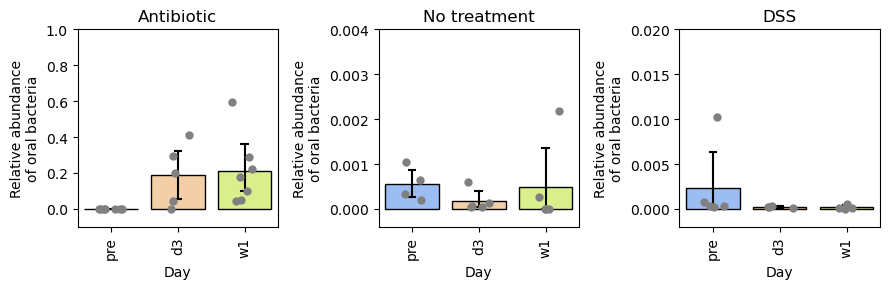

In [7]:
df2plot = df_meta[df_meta.OralFraction.notnull()]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
for k,treatment in enumerate(["Antibiotic","No treatment","DSS"]):
    _ = ax[k].set_xticklabels(ax[k].get_xticklabels(), rotation=90)
    _ = sns.barplot(
        x="Day", 
        y="OralFraction", 
        data=df2plot[df2plot.Treatment==treatment],
        order=['pre','d3','w1'],
        palette=[(141/255,186/255,255/255),(255/255,208/255,154/255),(227/255,255/255,124/255)],
        edgecolor="black",
        errcolor="black",
        errwidth=1.5,
        capsize = 0.1,
        ax=ax[k]
    )
    _ = sns.stripplot(
        x="Day",
        y="OralFraction",
        data=df2plot[df2plot.Treatment==treatment],
        order=['pre','d3','w1'],
        dodge=True,
        color="gray",
        edgecolor='k',
        facecolor='gray',
        size=6,
        jitter=0.2,
        ax=ax[k]
    )

    if k==0:
        _ = ax[k].set_ylim([-0.1,1])
    elif k==1:
        _ = ax[k].set_ylim([-0.0004,0.004])
    elif k==2:
        _ = ax[k].set_ylim([-0.002,0.02])
    
    _ = ax[k].set_ylabel('Relative abundance\nof oral bacteria')
    _ = ax[k].set_title(treatment)
        
_ = plt.tight_layout()

In [8]:
for group in ['Antibiotic','No treatment','DSS']:
    shared_mice = list(set(df2plot[(df2plot.Treatment==group)&(df2plot.Day=="pre")].MouseID).intersection(set(df2plot[(df2plot.Treatment==group)&(df2plot.Day=="w1")].MouseID)))
    res = wilcoxon(
        df2plot[(df2plot.Treatment==group)&(df2plot.Day=="pre")].set_index('MouseID').loc[shared_mice].OralFraction,
        df2plot[(df2plot.Treatment==group)&(df2plot.Day=="w1")].set_index('MouseID').loc[shared_mice].OralFraction,
        alternative='less'
    )
    print(group, ':', res)

Antibiotic : WilcoxonResult(statistic=0.0, pvalue=0.015625)
No treatment : WilcoxonResult(statistic=5.0, pvalue=0.5625)
DSS : WilcoxonResult(statistic=15.0, pvalue=1.0)


In [9]:
for group in ['Antibiotic','No treatment','DSS']:
    df2 = df2plot.loc[(df2plot.Treatment==group)&((df2plot.Day=='w1')|(df2plot.Day=='pre')), ['Day','OralFraction']]
    
    # Variances
    variances = df2.groupby('Day').var(ddof=1)
    # Mean variance
    mean_var = variances.mean().values[0]
    # Pooled standard deviation
    s_pooled = np.sqrt(mean_var)
    # Difference of the means
    diff_mean = abs(df2.groupby('Day').mean().diff().values[-1])
    # Cohen's d
    cohens_d = diff_mean / s_pooled
    
    print(group, ':', "Cohen's d = %.3f"%(cohens_d))

Antibiotic : Cohen's d = 1.552
No treatment : Cohen's d = 0.088
DSS : Cohen's d = 0.694


# Fig. 2e, 2f

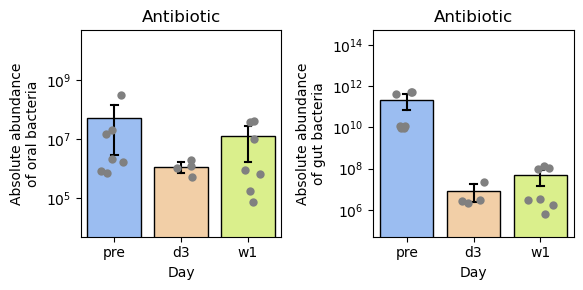

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

for k, col in enumerate(['OralLoad','GutLoad']):
    df2plot = df_meta[(df_meta.Treatment=='Antibiotic') & (df_meta.BodySite=='Fecal') & (df_meta.OralLoad > 0)]
    _ = sns.barplot(
        x="Day", 
        y=col, 
        order=['pre','d3','w1'],
        palette=[(141/255,186/255,255/255),(255/255,208/255,154/255),(227/255,255/255,124/255)],
        ax=ax[k], 
        data=df2plot,
        edgecolor="black",
        errcolor="black",
        errwidth=1.5,
        capsize = 0.1
    )
    _ = sns.stripplot(
        x="Day", 
        y=col,
        order=['pre','d3','w1'],
        ax=ax[k], 
        data=df2plot, 
        dodge=True, 
        color="gray",
        edgecolor='k',
        facecolor='gray',
        size=6,
        jitter=0.2
    )
    
    _ = ax[k].set_title('Antibiotic')

    if k==0:
        _ = ax[k].set_ylim([5e3,5e10])
        _ = ax[k].set_ylabel("Absolute abundance\nof oral bacteria")
    elif k==1:
        _ = ax[k].set_ylim([5e4,5e14])
        _ = ax[k].set_ylabel("Absolute abundance\nof gut bacteria")
    _ = ax[k].set_yscale('log')

_ = plt.tight_layout()

In [11]:
for col in ['OralLoad','GutLoad']:
    shared_mice = list(set(df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="pre")&(df2plot[col].notnull())].MouseID).intersection(set(df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="w1")&(df2plot[col].notnull())].MouseID)))
    if col=='OralLoad':
        res = wilcoxon(
            df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="pre")].set_index('MouseID').loc[shared_mice][col],
            df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="w1")].set_index('MouseID').loc[shared_mice][col],
            alternative='less'
        )
    else:
        res = wilcoxon(
            df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="pre")].set_index('MouseID').loc[shared_mice][col],
            df2plot[(df2plot.Treatment=='Antibiotic')&(df2plot.Day=="w1")].set_index('MouseID').loc[shared_mice][col],
            alternative='greater'
        )
    print(col, ':', res)

OralLoad : WilcoxonResult(statistic=11.0, pvalue=0.578125)
GutLoad : WilcoxonResult(statistic=21.0, pvalue=0.015625)


In [12]:
for col in ['OralLoad','GutLoad']:
    df2 = df2plot.loc[(df2plot.Treatment=='Antibiotic')&((df2plot.Day=='w1')|(df2plot.Day=='pre')), ['Day',col]]
    
    # Variances
    variances = df2.groupby('Day').var(ddof=1)
    # Mean variance
    mean_var = variances.mean().values[0]
    # Pooled standard deviation
    s_pooled = np.sqrt(mean_var)
    # Difference of the means
    diff_mean = abs(df2.groupby('Day').mean().diff().values[-1])
    # Cohen's d
    cohens_d = diff_mean / s_pooled
    
    print(col, ':', "Cohen's d = %.3f"%(cohens_d))

OralLoad : Cohen's d = 0.451
GutLoad : Cohen's d = 1.181


# Fig. 2g

number of samples w/ zero oral fraction = 5


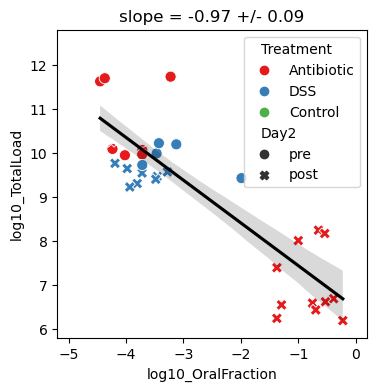

In [13]:
fig, ax = plt.subplots(figsize=(4,4))

df2plot = df_meta[df_meta.BodySite=='Fecal']
print("number of samples w/ zero oral fraction =", len(df2plot[df2plot.OralFraction==0]))
df2plot = df2plot[df2plot.OralFraction>0]

_ = sns.scatterplot(x="log10_OralFraction", y="log10_TotalLoad", hue='Treatment', style='Day2', hue_order=["Antibiotic","DSS","Control"], palette='Set1', data=df2plot, ax=ax, s=64)
_ = sns.regplot(x="log10_OralFraction", y="log10_TotalLoad", scatter=False, color='k', data=df2plot, ax=ax)
slope, intercept, r, p, se = linregress(df2plot.log10_OralFraction, df2plot.log10_TotalLoad)
_ = ax.set_title("slope = %2.2f +/- %2.2f"%(slope, se))
_ = ax.set_xlim([-5.2,0.2])
_ = ax.set_ylim([5.8,12.8])

In [14]:
Counter(df2plot.Treatment)

Counter({'Antibiotic': 18, 'DSS': 13, 'No treatment': 11})

# Test the pure Marker and Expansion hypotheses

In [15]:
df_ht = df_meta.loc[(df_meta.Treatment=='Antibiotic')&(df_meta.BodySite=='Fecal'), ['MouseID','TotalLoad','Day2','OralFraction']]
df_ht = df_ht.groupby(['MouseID','Day2'])[['OralFraction','TotalLoad']].agg(np.nanmean).reset_index()
df_ht = df_ht[df_ht.MouseID != "Abx_2B"]

oralload_pre_all = []
oralload_post_all = []
gutload_pre_all = []
gutload_post_all = []
for mid in set(df_ht.MouseID):
    oralfrac_pre = df_ht.loc[(df_ht.MouseID==mid)&(df_ht.Day2=='pre'),'OralFraction'].values[0]
    oralfrac_post = df_ht.loc[(df_ht.MouseID==mid)&(df_ht.Day2=='post'),'OralFraction'].values[0]
    totalload_pre = df_ht.loc[(df_ht.MouseID==mid)&(df_ht.Day2=='pre'),'TotalLoad'].values[0]
    totalload_post = df_ht.loc[(df_ht.MouseID==mid)&(df_ht.Day2=='post'),'TotalLoad'].values[0]
    gutload_pre_all.append(totalload_pre*(1-oralfrac_pre))
    gutload_post_all.append(totalload_post*(1-oralfrac_post))
    oralload_pre_all.append(totalload_pre*oralfrac_pre)
    oralload_post_all.append(totalload_post*oralfrac_post)

In [16]:
print("pure Expansion hypothesis", ":", wilcoxon(gutload_pre_all, gutload_post_all, alternative='greater'))
print(len(gutload_pre_all), len(gutload_post_all))

df2 = pd.DataFrame([gutload_pre_all+gutload_post_all,['pre']*len(gutload_pre_all)+['post']*len(gutload_post_all)]).T
df2.columns = ['Load','Time']
    
# Variances
variances = df2.groupby('Time').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('Time').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

pure Expansion hypothesis : WilcoxonResult(statistic=28.0, pvalue=0.0078125)
7 7
Cohen's d = 1.181


In [17]:
print("pure Marker hypothesis", ":", wilcoxon(oralload_pre_all, oralload_post_all, alternative='greater'))
print(len(oralload_pre_all), len(oralload_post_all))

df2 = pd.DataFrame([oralload_pre_all+oralload_post_all,['pre']*len(oralload_pre_all)+['post']*len(oralload_post_all)]).T
df2.columns = ['Load','Time']
    
# Variances
variances = df2.groupby('Time').var(ddof=1)
# Mean variance
mean_var = variances.mean().values[0]
# Pooled standard deviation
s_pooled = np.sqrt(mean_var)
# Difference of the means
diff_mean = abs(df2.groupby('Time').mean().diff().values[-1])
# Cohen's d
cohens_d = diff_mean / s_pooled

print("Cohen's d = %.3f"%(cohens_d))

pure Marker hypothesis : WilcoxonResult(statistic=15.0, pvalue=0.46875)
7 7
Cohen's d = 0.449


# Table S2

In [18]:
for treatment in ['No treatment','Antibiotic','DSS']:
    df_grouping = df_meta.loc[df_relabun.index]
    all_samples = list(set(df_grouping[df_grouping.Treatment==treatment].index).intersection(df_relabun.index))

    # group labels
    df_grouping = df_grouping.loc[all_samples]
    group = ['pre_'+bs.lower() if day=='pre' else 'post_'+bs.lower() for bs, day in zip(df_grouping.BodySite, df_grouping.Day)]

    # add group label to relative abundance
    df_relabun_tm = df_relabun.loc[all_samples]
    df_relabun_tm['Group'] = group
    df_relabun_tm.to_csv("community_distance_comparison/relative_abundance_%s.csv"%(treatment))
    
    # add group label to distance matrix
    df_dist = pd.DataFrame(pairwise_distances(df_relabun.loc[all_samples], metric='braycurtis'), index=all_samples, columns=all_samples)
    print("# samples (%s) = %d"%(treatment, len(df_dist.columns)))
    df_dist['Group'] = group
    df_dist.to_csv("community_distance_comparison/distance_matrix_%s.csv"%(treatment))
    
    print(Counter(df_dist.Group))

# samples (No treatment) = 27
Counter({'post_fecal': 10, 'post_oral': 9, 'pre_fecal': 4, 'pre_oral': 4})
# samples (Antibiotic) = 35
Counter({'post_fecal': 12, 'pre_oral': 8, 'post_oral': 8, 'pre_fecal': 7})
# samples (DSS) = 22
Counter({'post_fecal': 9, 'pre_fecal': 5, 'post_oral': 5, 'pre_oral': 3})


In [19]:
df_adonis = None
for treatment in ['Antibiotic','No treatment','DSS']:
    df_tmp = pd.read_csv("community_distance_comparison/pairwise_adonis_%s_result.csv"%(treatment), index_col=0)
    df_tmp[treatment] = ["%2.3f (%2.3f)"%(x,y) for x,y in zip(df_tmp.R2, df_tmp['p.adjusted'])]
    df_tmp = df_tmp.rename(
        {"post_fecal vs pre_oral":"pre_oral vs post_fecal",
         "pre_fecal vs pre_oral":"pre_oral vs pre_fecal",
         "post_oral vs pre_oral":"pre_oral vs post_oral",
         "post_fecal vs pre_fecal":"pre_fecal vs post_fecal",
         "post_fecal vs post_oral":"post_oral vs post_fecal",
         "post_oral vs pre_fecal":"pre_fecal vs post_oral"
        }
    )
    if df_adonis is None:
        df_adonis = deepcopy(df_tmp[[treatment]])
    else:
        df_adonis = pd.merge(df_adonis, df_tmp[[treatment]], left_index=True, right_index=True, how='inner')
df_adonis

,Antibiotic,No treatment,DSS
pairs,,,
pre_oral vs post_oral,0.136 (0.066),0.205 (0.058),0.411 (0.086)
pre_oral vs post_fecal,0.149 (0.055),0.916 (0.003),0.559 (0.029)
pre_oral vs pre_fecal,0.330 (0.004),0.946 (0.044),0.862 (0.033)
post_oral vs post_fecal,0.120 (0.066),0.762 (0.001),0.098 (0.273)
pre_fecal vs post_oral,0.417 (0.002),0.707 (0.003),0.258 (0.055)
pre_fecal vs post_fecal,0.197 (0.032),0.085 (0.305),0.315 (0.029)


# Extended Data Fig. 1b

% explained:  [0.30433668 0.08331548]


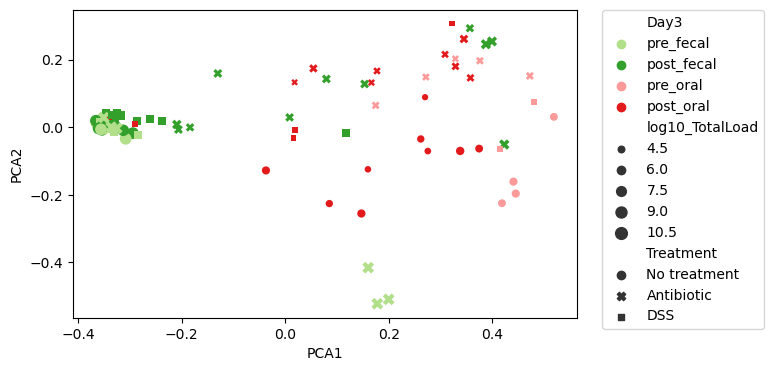

In [20]:
fig, ax = plt.subplots(figsize=(6.5,4))

samples_selected = list(set(df_meta.index).intersection(set(df_relabun.index)))
distm = pairwise_distances(df_relabun.loc[samples_selected], metric='braycurtis', n_jobs=-1)
pcoa_obj = pcoa(distm, method='eigh', number_of_dimensions=2, inplace=False)
print("% explained: ", pcoa_obj.proportion_explained.values)
pcoa_df = pd.DataFrame(data=np.vstack((pcoa_obj.samples.T,
                                       df_meta.loc[samples_selected].index,
                                       df_meta.loc[samples_selected].BodySite,
                                       df_meta.loc[samples_selected].Day,
                                       df_meta.loc[samples_selected].MouseID,
                                       df_meta.loc[samples_selected].Day3,
                                       df_meta.loc[samples_selected].Treatment,
                                       df_meta.loc[samples_selected].log10_TotalLoad
                                      )).T, 
                       columns=('PCA1', 'PCA2', 'SampleID', 'BodySite', 'Day', 'MouseID', 'Day3', 'Treatment', 'log10_TotalLoad'))
pcoa_df.PCA1 = pcoa_df.PCA1.astype(float)
pcoa_df.PCA2 = pcoa_df.PCA2.astype(float)

_ = sns.scatterplot(x='PCA1', y='PCA2', hue='Day3', style='Treatment', size='log10_TotalLoad', 
                    hue_order=['pre_fecal','post_fecal','pre_oral','post_oral'],
                    style_order=['No treatment','Antibiotic','DSS'], size_norm=(4,10),
                    edgecolor='None', data=pcoa_df, palette=sns.color_palette("Paired")[2:], ax=ax)
_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Extended Data Fig. 2

In [21]:
all_mice = list(set(df_meta.MouseID))
for mice in all_mice:
    df_meta2 = df_meta[df_meta.MouseID==mice]
    df_meta2 = df_meta2.loc[list(set(df_relabun.index).intersection(set(df_meta2.index)))]
    treatment = list(set(df_meta2.Treatment))[0]

    # fecal sample at day 0
    fecal_day0 = list(df_meta2[(df_meta2.Day=='pre') & (df_meta2.BodySite=='Fecal')].index)
    assert len(fecal_day0) <= 1
    if len(fecal_day0) == 1:
        fecal_day0 = fecal_day0[0]
    else:
        continue

    # oral sample at day 0
    oral_day0 = list(df_meta2[(df_meta2.Day=='pre') & (df_meta2.BodySite=='Oral')].index)
    assert len(oral_day0) <= 1
    if len(oral_day0) == 1:
        oral_day0 = oral_day0[0]
    else:
        continue

    # find oral fraction in fecal samples
    feast_meta = []
    group_id = 1
    
    # add source
    feast_meta.append([fecal_day0, '%s: fecal sample before treatment (%s)'%(mice, treatment), 'Source', 'NA'])
    feast_meta.append([oral_day0, '%s: oral sample before treatment (%s)'%(mice, treatment), 'Source', 'NA'])

    # add sink
    df_meta2 = df_meta2[df_meta2.Day != 'pre']
    for sid, bs, day in zip(df_meta2.index, df_meta2.BodySite, df_meta2.Day):
        feast_meta.append([sid, '%s: %s sample at %s post treatment (%s)'%(mice, bs.lower(), day, treatment), 'Sink', str(group_id)])
        group_id += 1

    df_feastmeta = pd.DataFrame(feast_meta, columns=['SampleID','Env','SourceSink','id'])
    df_feastmeta.to_csv('FEAST/metadata_%s.txt'%(mice), sep="\t", index=False)

    df_count2 = deepcopy(df_count.loc[df_feastmeta.SampleID])
    df_count2 = df_count2.loc[:, (df_count2 != 0).any(axis=0)]
    df_count2.loc[df_feastmeta.SampleID].T.to_csv('FEAST/asv_%s.txt'%(mice), sep="\t")

In [22]:
df_feast_output = None
for file in os.listdir("FEAST"):
    if '_source_contributions_matrix.txt' in file:
        mouse = file.rstrip('_source_contributions_matrix.txt')
        fecal_sample = list(df_meta[(df_meta.MouseID==mouse) & (df_meta.Day=='pre') & (df_meta.BodySite=='Fecal')].index)[0]
        oral_sample = list(df_meta[(df_meta.MouseID==mouse) & (df_meta.Day=='pre') & (df_meta.BodySite=='Oral')].index)[0]
        
        df_tmp = pd.read_csv("feast/%s"%(file), sep="\t").stack().reset_index()
        df_tmp.columns = ['Sink','Source','Percentage']
        df_tmp = df_tmp[df_tmp.Sink.str.contains('fecal sample') & df_tmp.Source.str.contains('oral sample')]
        df_tmp['Source'] = oral_sample
        df_tmp.Sink = [x.split(':')[0].split('_'+mouse)[0] for x in df_tmp.Sink]

        if df_feast_output is None:
            df_feast_output = deepcopy(df_tmp)
        else:
            df_feast_output = pd.concat([df_feast_output, df_tmp])
df_feast_output.reset_index(drop=True)

,Sink,Source,Percentage
0,F_Day_3_Abx_C,O_Day_0_Abx_C,1.003789e-01
1,F_Day_7_DSS_B,O_Day_0_DSS_B,2.942500e-05
2,F_Day_3_DSS_B,O_Day_0_DSS_B,2.344989e-04
3,KP_Exp_8_D8_AVN3,KP_Exp_8_D0_OR_AVN3,1.137580e-01
4,F_Day_3_DSS_D,O_Day_0_DSS_D,4.781226e-04
5,F_Day_7_DSS_D,O_Day_0_DSS_D,4.679538e-30
6,F_Day_7_Abx_E,O_Day_0_Abx_E,7.487652e-02
7,F_Day_3_Abx_E,O_Day_0_Abx_E,3.372170e-01
8,F_Day_3_Control_A,O_Day_0_Control_A,7.111667e-04
9,F_Day_7_Control_A,O_Day_0_Control_A,3.894156e-04


number of samples w/ zero oral fraction = 3


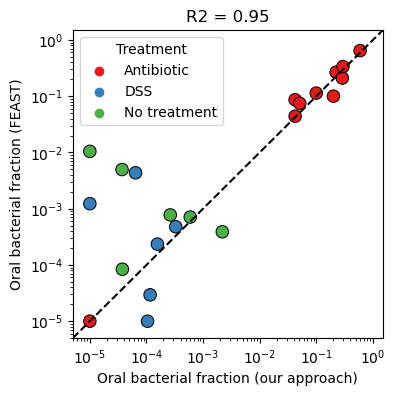

In [23]:
fig, ax = plt.subplots(figsize=(4,4))

df2plot = pd.merge(
    df_meta[df_meta.BodySite=="Fecal"],
    pd.read_csv("FEAST/FEAST_output.csv", index_col=0),
    left_index=True,
    right_index=True,
    how='inner')

print("number of samples w/ zero oral fraction =", len(df2plot[df2plot.OralFraction==0]))
df2plot.loc[df2plot.OralFraction<1e-5,'OralFraction'] = 1e-5
df2plot.loc[df2plot.Percentage<1e-5,'Percentage'] = 1e-5

_ = sns.scatterplot(x='OralFraction', y='Percentage', hue='Treatment', 
                    hue_order=['Antibiotic','DSS','No treatment'], s=81,
                    edgecolor='k', data=df2plot, palette="Set1", ax=ax)
_ = ax.plot([5e-6,1.5],[5e-6,1.5],'k--')
_ = ax.set_xlim([5e-6,1.5])
_ = ax.set_ylim([5e-6,1.5])
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel("Oral bacterial fraction (our approach)")
_ = ax.set_ylabel("Oral bacterial fraction (FEAST)")

r2 = r2_score(y_true=df2plot.Percentage, y_pred=df2plot.OralFraction)
_ = ax.set_title("R2 = %2.2f"%(r2))

In [24]:
Counter(df2plot.Treatment)

Counter({'Antibiotic': 10, 'No treatment': 6, 'DSS': 6})

# Extended Data Fig. 3

Abx_1A
Counter({'red': 8, 'blue': 1, 'black': 1})
Abx_1B
Counter({'red': 10, 'black': 1})
Abx_1C
Counter({'red': 2, 'blue': 1, 'black': 1})
Abx_2A
Counter({'red': 15, 'blue': 3, 'black': 1})
Abx_2B
Counter({'red': 16, 'black': 1})
Abx_2C
Counter({'red': 8, 'blue': 1, 'black': 1})
Abx_2D
Counter({'red': 7, 'blue': 2, 'black': 1})
Abx_2E
Counter({'red': 21, 'blue': 2, 'black': 1})


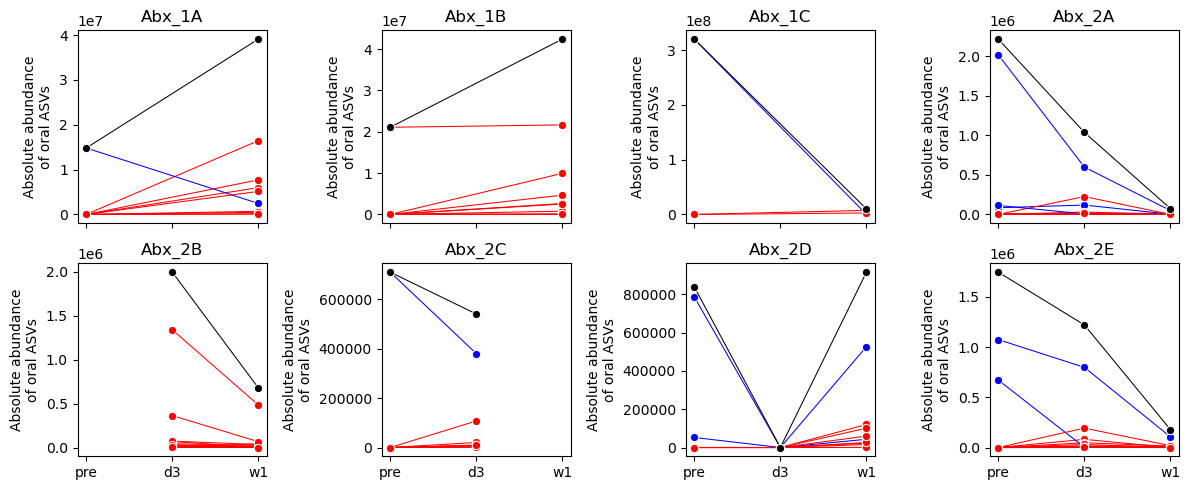

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12,5), sharex=True,)

df_oral_asvs = pd.read_excel("ST1_oralASV_mouse.xlsx", sheet_name='Table S1a', index_col=0)
filtered_oral_asvs = list(df_oral_asvs.index)

for k,mouse in enumerate(['Abx_1A','Abx_1B','Abx_1C','Abx_2A','Abx_2B','Abx_2C','Abx_2D','Abx_2E']):
    corresponding_oral_sample = list(df_meta[(df_meta.Day=='pre') & (df_meta.MouseID==mouse) & (df_meta.BodySite=='Oral')].index)[0]
    oral_asvs_in_day0 = list(df_relabun.loc[corresponding_oral_sample][df_relabun.loc[corresponding_oral_sample]>0].index)
    mouse_specific_oral_asv = list(set(oral_asvs_in_day0).intersection(set(filtered_oral_asvs)))

    df_meta2 = df_meta[(df_meta.MouseID==mouse) & (df_meta.BodySite=='Fecal')]
    res = []
    for asv in mouse_specific_oral_asv:
        for day in ['pre','d3','w1']:
            if day in list(df_meta2.Day):
                sid = df_meta2[df_meta2.Day==day].index[0]
                if sid in list(df_relabun.index):
                    qpcr = df_meta2.loc[sid,'TotalLoad']
                    res.append([asv, day, df_relabun.loc[sid,asv]*qpcr])
                else:
                    res.append([asv, day, np.NaN])
            else:
                res.append([asv, day, np.NaN])
    df_res = pd.DataFrame(res, columns=['ASV','Day','AbsAbun'])
    
    # find asvs that had increased or decreased abundance
    all_asvs = list(set(df_res.ASV))
    res2 = []
    for asv in all_asvs:
        relabun_pre = df_res.loc[(df_res.ASV==asv)&(df_res.Day=='pre'),'AbsAbun'].values[0]
        relabun_post = np.nanmean(df_res[(df_res.ASV==asv) & (df_res.Day!='pre')].AbsAbun.values)
        if relabun_pre >0 or relabun_post >0:
            if relabun_pre > relabun_post:
                res2.append([asv, 'blue'])
            else:
                res2.append([asv, 'red'])
    df_res2 = pd.DataFrame(res2, columns=['ASV','Color'])
    df_res = pd.merge(df_res, df_res2, left_on='ASV', right_on='ASV', how='inner')

    # add sum
    df_res3 = df_res[df_res.AbsAbun.notnull()].groupby('Day')['AbsAbun'].agg(np.sum).reset_index()
    df_res3['ASV'] = 'ASV_10000'
    df_res3['Color'] = 'black'
    df_res3 = df_res3[df_res.columns]
    df_res = pd.concat([df_res, df_res3], axis=0).reset_index(drop=True)
    
    print(mouse)
    print(Counter(df_res.drop_duplicates('ASV').Color))
    
    # plot
    kc = k % 4
    kr = int(k/4)
    _ = sns.lineplot(
        x="Day", 
        y="AbsAbun", 
        hue="ASV", 
        ax=ax[kr,kc], 
        data=df_res, 
        legend=False,
        marker='o',
        size=100,
        palette = dict(zip(df_res[['ASV','Color']].drop_duplicates().ASV, df_res[['ASV','Color']].drop_duplicates().Color))
    )
    
    _ = ax[kr,kc].set_title(mouse)
    _ = ax[kr,kc].set_xlabel('')
    _ = ax[kr,kc].set_ylabel('Absolute abundance\nof oral ASVs')
_ = plt.tight_layout()